In [1]:
import os
import time
import sys
from pathlib import Path
import torch
import numpy as np
import psdr_jit as psdr
import drjit
from drjit.cuda.ad import Int as IntD, Float as FloatD, Matrix4f as Matrix4fD, Array3f as Vector3fD, Array2f as Vector2fD
from drjit.cuda import Float as FloatC, Matrix4f as Matrix4fC, Array3f as Vector3fC
from drjit.cuda import PCG32 as PCG32C, UInt64 as UInt64C
from image_util import *
import matplotlib.pyplot as plt
from PIL import Image
from embedder import *
from torch import nn
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"




In [2]:
class MyColorBSDF(psdr.BSDF):
    def __init__(self, albedo):
        psdr.BSDF.__init__(self)
        self.texture = psdr.Bitmap3fD(albedo)

    def anisotropic(self):
        return False

    def to_string(self):
        return "MyColorBSDF[id=" + self.id + "]";

    def eval(self, its, wo, active):
        return self.texture.eval(its.uv) & active


In [3]:
class SimpleIntegrator():
    def __init__(self, spp, width, height):
        self.width = width
        self.height = height
        self.num_pixels = self.width*self.height
        self.spp = spp
        self.sampler = psdr.Sampler()
        if self.spp > 0:
            self.sampler.seed(drjit.arange(UInt64C, self.spp*self.num_pixels))

    def Li(self, scene, ray, valid=True):
        ray = psdr.Ray(ray.o, ray.d)
        its = scene.ray_intersectAD(ray, valid)
#         print("virtual call")
        value = its.shape.bsdf().eval(its, its.wi, valid)
#         print("Li")
#         print(drjit.mean(drjit.mean(value)))
        value[drjit.isnan(value)] = 0.
        value[drjit.isinf(value)] = 0.
        return value

    def render(self, scene, sensor_id):
        result = self.render_spp(scene, sensor_id)
        return result

    def render_spp(self, scene, sensor_id):
        result = drjit.zeros(Vector3fD, self.num_pixels)
        if self.spp == 0:
            return result
        with drjit.suspend_grad():
            idx = drjit.arange(IntD, self.num_pixels)
            num_samples = self.num_pixels * self.spp
            idx = drjit.arange(IntD, num_samples)
            idx = idx // self.spp
            dx, dy = drjit.meshgrid(drjit.arange(FloatD, self.width), drjit.arange(FloatD, self.height))
            samples_base = drjit.gather(Vector2fD, Vector2fD(dx, dy), idx)
            samples = (samples_base + self.sampler.next_2d())/Vector2fD(self.width, self.height);
            ray = scene.sensor[sensor_id].sample_primary_ray(samples);
        with drjit.resume_grad():
            value = self.Li(scene, ray)
            drjit.scatter_reduce(drjit.ReduceOp.Add, result, value, idx)
            result /= self.spp
        return result

In [4]:
sc = psdr.Scene()

sc.opts.spp = 64
sc.opts.sppe = 0
sc.opts.sppse = 0 
sc.opts.width = 512 
sc.opts.height = 512 

sc.opts.log_level = 0



In [5]:
sensor = psdr.PerspectiveCamera(30, 0.000001, 10000000.)
to_world = Matrix4fD([[1.,0.,0.,0.],
                     [0.,0.,-1.,5.],
                     [0.,1.,0.,0.],
                     [0.,0.,0.,1.],])
sensor.to_world = to_world
sc.add_Sensor(sensor)

In [6]:
mybsdf = MyColorBSDF("./data/texture/illya.exr")
sc.add_BSDF(mybsdf, "illya")
sc.add_Mesh("./data/uv_plane.obj", Matrix4fC([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]), "illya", None, True)
sc.configure()

In [7]:
integrator = SimpleIntegrator(sc.opts.spp, sc.opts.height, sc.opts.width)

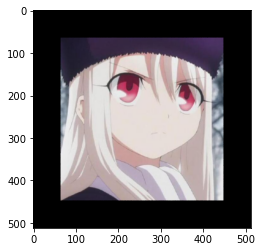

In [8]:
img_target = integrator.render(sc, 0)
img = img_target.numpy().reshape((sc.opts.width, sc.opts.height, 3))
img = to_srgb(np.asarray(img))
imgplot = plt.imshow(img)


In [9]:
class RenderFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, integrator, scene, sensor_id, param):
        with drjit.suspend_grad():
            scene.param_map["BSDF[0]"].texture.data = Vector3fD(param)
            drjit.eval(scene.param_map["BSDF[0]"].texture.data)
#             print("foward pass")
            psdr_image = integrator.render(scene, 0)
#             print("renderC")
            image = psdr_image.torch()
            ctx.scene = scene
            ctx.integrator = integrator
            ctx.param = param
            return image.reshape((scene.opts.height, scene.opts.width, 3))

    @staticmethod
    def backward(ctx, grad_out):
        with drjit.resume_grad():
#             print("backward")
            drjit_param = ctx.scene.param_map["BSDF[0]"].texture.data
            drjit.enable_grad(drjit_param)
            image_grad = Vector3fC(grad_out.reshape(-1,3))
#             print("backward render")
            image = ctx.integrator.render(ctx.scene, 0)
#             print("complete renderD")
            tmp = drjit.dot(image_grad, image)
#             print("jit backward")
            drjit.backward(tmp)
#             print("jit backward done")
            grad_tmp = drjit.grad(drjit_param)
#             print("grad")
#             print(drjit.mean(drjit.mean(drjit.abs(grad_tmp))))
#             drjit.disable_grad(drjit_param)
            param_grad = torch.nan_to_num(grad_tmp.torch().cuda())
            
#             del drjit_param, tmp, grad_tmp

            return tuple([None]*3 + [param_grad])

class Renderer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, integrator, scene, sensor_id, param):
        image = RenderFunction.apply(integrator,scene,sensor_id,param)
        return image

In [10]:
fembed, embed_dim = get_embedder(10, 2)
print("embed_dim", embed_dim)
layer_size = 64
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(embed_dim, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, layer_size),
          nn.ReLU(),
          nn.Linear(layer_size, 3),
          nn.Sigmoid()
        ).cuda()
    def forward(self, x):
        return self.layers(x)

embed_dim 42


In [11]:
mlp_image = MLP()

In [12]:
x = np.linspace(0, 1, 512)
y = np.linspace(0, 1, 512)
debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()
debug_color = (torch.transpose(debug_color.reshape(2, -1), 0, 1))
data_in = fembed(debug_color)
opt_map = mlp_image(data_in)



<ipython-input-12-8ed18736116b>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  debug_color = torch.tensor(np.meshgrid(x, y), dtype=torch.float32).cuda()


In [13]:
psdr_render = Renderer()
target_img = img_target.torch().reshape((sc.opts.width, sc.opts.height, 3))


it: 0 loss 0.12823566794395447


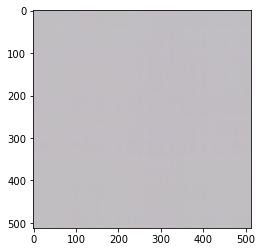

it: 100 loss 0.05375298857688904


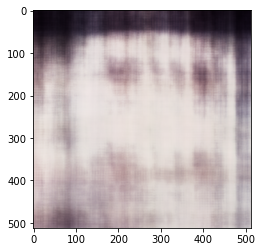

it: 200 loss 0.0306607186794281


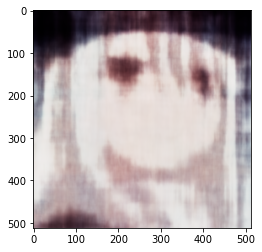

it: 300 loss 0.025519778952002525


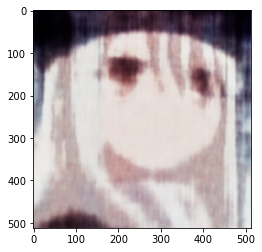

it: 400 loss 0.023543234914541245


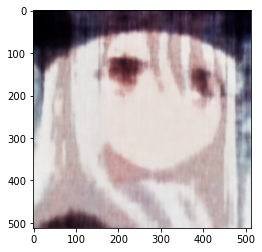

it: 500 loss 0.021980619058012962


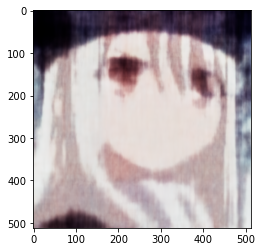

it: 600 loss 0.021205589175224304


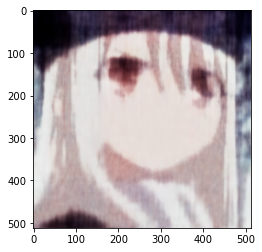

it: 700 loss 0.020247353240847588


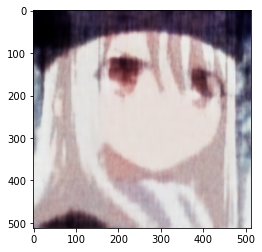

it: 800 loss 0.01949675753712654


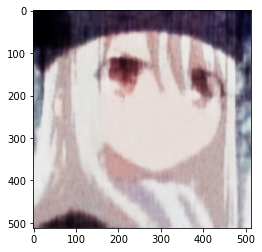

it: 900 loss 0.019093159586191177


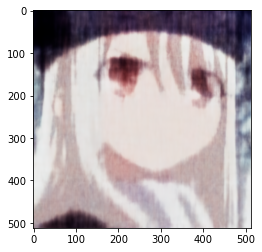

it: 1000 loss 0.018520591780543327


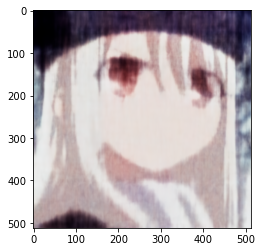

In [14]:
optimizer = torch.optim.Adam(mlp_image.parameters(), lr=1e-3)
num_iter = 1000

# mlp_image.load_state_dict(torch.load("lastest.pt"))
# mlp_image.eval()

for it in range(num_iter+1):
    optimizer.zero_grad()
#     torch.save(mlp_image.state_dict(), "lastest.pt")

    
#     break
    opt_map = mlp_image(data_in)#.reshape((512, 512, 3))
    
#     loss = (target_img.reshape((-1, 3))-opt_map).abs().mean()

    curr_img = psdr_render(integrator, sc, 0, opt_map)
    
#     psdr_image = integrator.render(sc, 0)
#     break
    loss = (target_img-curr_img).abs().mean()

    loss.backward()
#     print("out")

    optimizer.step()

    if it % 100 == 0:
        print("it:", it, "loss", loss.item())
#         img = to_srgb(curr_img.detach().cpu().numpy().reshape((sc.opts.width, sc.opts.height, 3)))
        img = to_srgb(opt_map.detach().cpu().numpy().reshape((sc.opts.width, sc.opts.height, 3)))
        imgplot = plt.imshow(img)
        plt.show()
